In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "8"

In [2]:
import sys
sys.path.append(os.path.realpath('../../..'))

In [3]:
from tqdm.auto import tqdm
from typing import List
import re
from typing import List, Tuple, Dict
from data.dataset import GraphDataset, ReimburseGraphDataset, DataAugmentationLevel, DialogNode, NodeType
import seaborn as sns
import pandas

/mount/arbeitsdaten/asr-2/vaethdk/virtualenvs/cts_en/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DEVICE = 'cuda:0'
import torch

In [5]:
human_data_train = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.NONE, resource_dir="../../../resources/")
human_data_test = ReimburseGraphDataset('en/reimburse/test_graph.json', 'en/treimburse/est_answers.json', False, augmentation=DataAugmentationLevel.NONE, resource_dir="../../../resources/")
generated_data_train_v1 = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY, augmentation_path="en/reimburse/generated/train_questions_v1.json", resource_dir="../../../resources/")
generated_data_train_v2 = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY, augmentation_path="en/reimburse/generated/train_questions_v2.json", resource_dir="../../../resources/")
generated_data_train_v3 = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY, augmentation_path="en/reimburse/generated/train_questions_v3.json", resource_dir="../../../resources/")

- not using synonyms
===== Dataset Statistics =====
- files:  en/train_graph.json en/train_answers.json
- synonyms: False
- depth: 20  - degree: 13
- answers: 73
- questions: 279
- loaded original data: True
- loaded generated data: False
- not using synonyms
===== Dataset Statistics =====
- files:  en/test_graph.json en/test_answers.json
- synonyms: False
- depth: 20  - degree: 13
- answers: 73
- questions: 173
- loaded original data: True
- loaded generated data: False
- Loading questions from  ../../../resources/en/generated/train_questions_v1.json
- not using synonyms
===== Dataset Statistics =====
- files:  en/train_graph.json en/train_answers.json
- synonyms: False
- depth: 20  - degree: 13
- answers: 73
- questions: 1012
- loaded original data: False
- loaded generated data: True
- Loading questions from  ../../../resources/en/generated/train_questions_v2.json
- not using synonyms
===== Dataset Statistics =====
- files:  en/train_graph.json en/train_answers.json
- synonyms: Fals

# CALCULATING PERPLEXITY

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained('gpt2-large', cache_dir="/mount/arbeitsdaten/asr-2/vaethdk/resources/weights/")

In [7]:
model = AutoModelForCausalLM.from_pretrained('gpt2-large', cache_dir="/mount/arbeitsdaten/asr-2/vaethdk/resources/weights/")

In [8]:
model = model.eval().to('cuda:0')

In [42]:
# import transformers 

# # set quantization configuration to load large model with less GPU memory
# # this requires the `bitsandbytes` library
# bnb_config = transformers.BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type='nf4',
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

# model_id = 'meta-llama/Llama-2-70b-chat-hf'
# model = transformers.AutoModelForCausalLM.from_pretrained(
#     model_id,
#     trust_remote_code=True,
#     quantization_config=bnb_config,
#     device_map='auto'
# )

In [10]:
def calculate_ppl(node: DialogNode) -> List[float]:
    """ 
    Returns 
        A list of token probabilities (one tensor per question)
        A list of token indices
    """
    # generate prompt
    ppls = []
    with torch.no_grad():
        for question in node.questions:
            prompt = f"{question.text if question.text.strip().endswith('?') else question.text + '?'} {node.text}"
            # forward prompt
            inputs = tokenizer(prompt, return_tensors='pt').input_ids.to('cuda:0')
            output = model(input_ids=inputs, labels=inputs)
            ppl = torch.exp(output.loss.squeeze())
            ppls.append(ppl.item())
    return ppls


In [11]:
def load_ppl(ppl_file: str) -> List[float]:
    # Calculate perplexity of human data 
    ppls = torch.load(ppl_file, map_location=lambda storage, loc: storage)
    perplexities = []
    for node_key in ppls:
        node_data = ppls[node_key] # list with probabilities per question
        perplexities.extend(node_data)
    print(ppl_file, ":", len(perplexities), "samples")
    return perplexities

### HUMAN QUESTION PERPLEXITY

In [12]:
data = {}
for node in tqdm(human_data_train.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        node_question_ppls = calculate_ppl(node)
        data[node.key] = node_question_ppls
torch.save(data, "human_question_probs.pt")

100%|██████████| 80/80 [00:07<00:00, 10.61it/s]


In [13]:
data = {}
for node in tqdm(human_data_test.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        node_question_ppls = calculate_ppl(node)
        data[node.key] = node_question_ppls
torch.save(data, "human_question_probs_testdata.pt")

100%|██████████| 80/80 [00:04<00:00, 18.55it/s]


In [14]:
data = {}
for node in tqdm(generated_data_train_v1.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        node_question_ppls = calculate_ppl(node)
        data[node.key] = node_question_ppls
torch.save(data, "generated_question_probs_v1.pt")

100%|██████████| 80/80 [00:20<00:00,  3.93it/s]


In [15]:
data = {}
for node in tqdm(generated_data_train_v2.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        node_question_ppls = calculate_ppl(node)
        data[node.key] = node_question_ppls
torch.save(data, "generated_question_probs_v2.pt")

100%|██████████| 80/80 [00:20<00:00,  3.94it/s]


In [16]:
data = {}
for node in tqdm(generated_data_train_v3.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        node_question_ppls = calculate_ppl(node)
        data[node.key] = node_question_ppls
torch.save(data, "generated_question_probs_v3.pt")

100%|██████████| 80/80 [00:10<00:00,  7.50it/s]


In [17]:
df = pandas.DataFrame(
    [{"source": "human_questions_train", "ppl": ppl} for ppl in load_ppl('human_question_probs.pt')] + 
    [{"source": "human_questions_test", "ppl": ppl} for ppl in load_ppl('human_question_probs_testdata.pt')] +
    [{"source": 'generated v1', "ppl": ppl} for ppl in load_ppl('generated_question_probs_v1.pt')] +
    [{"source": 'generated v2', "ppl": ppl} for ppl in load_ppl('generated_question_probs_v2.pt')] +
    [{"source": 'generated v3', "ppl": ppl} for ppl in load_ppl('generated_question_probs_v3.pt')]
)

human_question_probs.pt : 269 samples
human_question_probs_testdata.pt : 167 samples
generated_question_probs_v1.pt : 800 samples
generated_question_probs_v2.pt : 800 samples
generated_question_probs_v3.pt : 417 samples


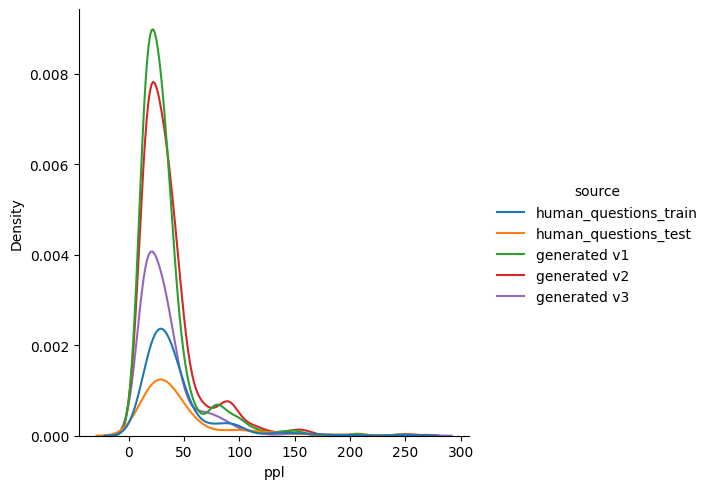

In [22]:
sns.displot(df.reset_index(drop=True), x="ppl", kind="kde", hue='source', common_norm=True)